# Consistency of MWPM on RSC

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
json_filename: str = "rsc-consistency-mwpf.json"  # where to save the result, must be provided
code: str = "rsc(d=5,p=0.001)"
noise: str = "none"
decoder: str = "mwpf"

slurm_maximum_jobs: int = 100
slurm_cores_per_node: int = 10  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 4  # 4GB per job
slurm_walltime: str = "11:00:00"  # 11 hours (adaptively shutdown if no more jobs)
slurm_partition: str = "scavenge"

local_maximum_jobs: int = 10

min_shots: int = 10_000_000  # p_L between 6.7e-5 ~ 3.9e-5

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [4]:
# cluster_node_limit
label_vec = list(range(50))

jobs = [MonteCarloJob(label=label) for label in label_vec]


def monte_carlo_function(shots: int, label: int = 1) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=decoder, code=code, noise=noise, max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, 0)

(1000, LogicalErrorResult(errors=0, discards=0))

### Define the strategy to submit jobs

In [5]:
min_shots_submitter = MinShotsSubmitter(shots=min_shots)
precision_submitter = PrecisionSubmitter(time_limit=100*3600, min_precision=0.3, target_precision=0.01)
precision_submitter_2 = PrecisionSubmitter(time_limit=100*3600, min_precision=0.02, target_precision=0.003)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    submit += precision_submitter_2(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

In [6]:
from qec_lego_bench.hpc.monte_carlo import *
import matplotlib.pyplot as plt
from IPython import display
from dataclasses import field
from typing import Optional

@dataclass
class ConsistencyPlotter:
    label_vec: list[int]

    hdisplay: display.DisplayHandle = field(
        default_factory=lambda: display.display("", display_id=True)
    )

    def __call__(self, executor: MonteCarloJobExecutor):
        x_vec = []
        y_vec = []
        err_vec = []
        for label in self.label_vec:
            job = executor.get_job(label=label)
            if job is None or job.result is None:
                continue
            x_vec.append(label)
            stats = job.result.stats_of(job)  # type: ignore
            y_vec.append(stats.failure_rate_value)
            err_vec.append(stats.failure_rate_uncertainty)
        if len(x_vec) == 0:
            return
        fig, ax = plt.subplots(1, 1)
        ax.clear()
        ax.errorbar(x_vec, y_vec, err_vec, label=f"noise={noise}")
        ax.set_xlabel("label")
        ax.set_ylabel("logical error rate $p_L$")
        ax.set_xlim(min(self.label_vec) - 1, max(self.label_vec) + 1)
        ax.set_ylim(5e-5, 5e-4)
        ax.set_yscale("log")
        fig.legend()
        self.hdisplay.update(fig)
        plt.close(fig)

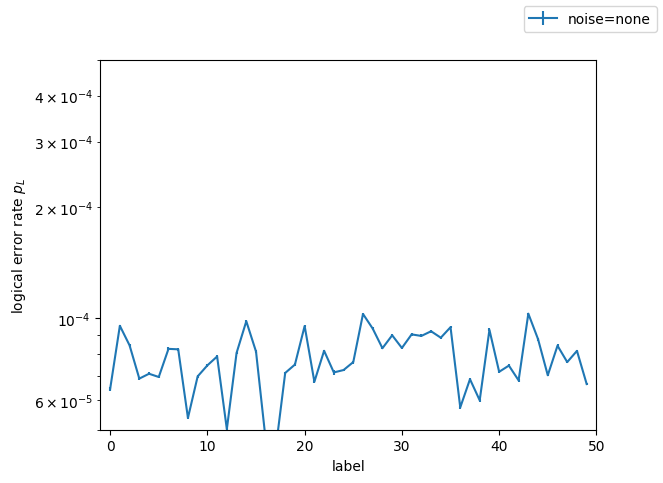

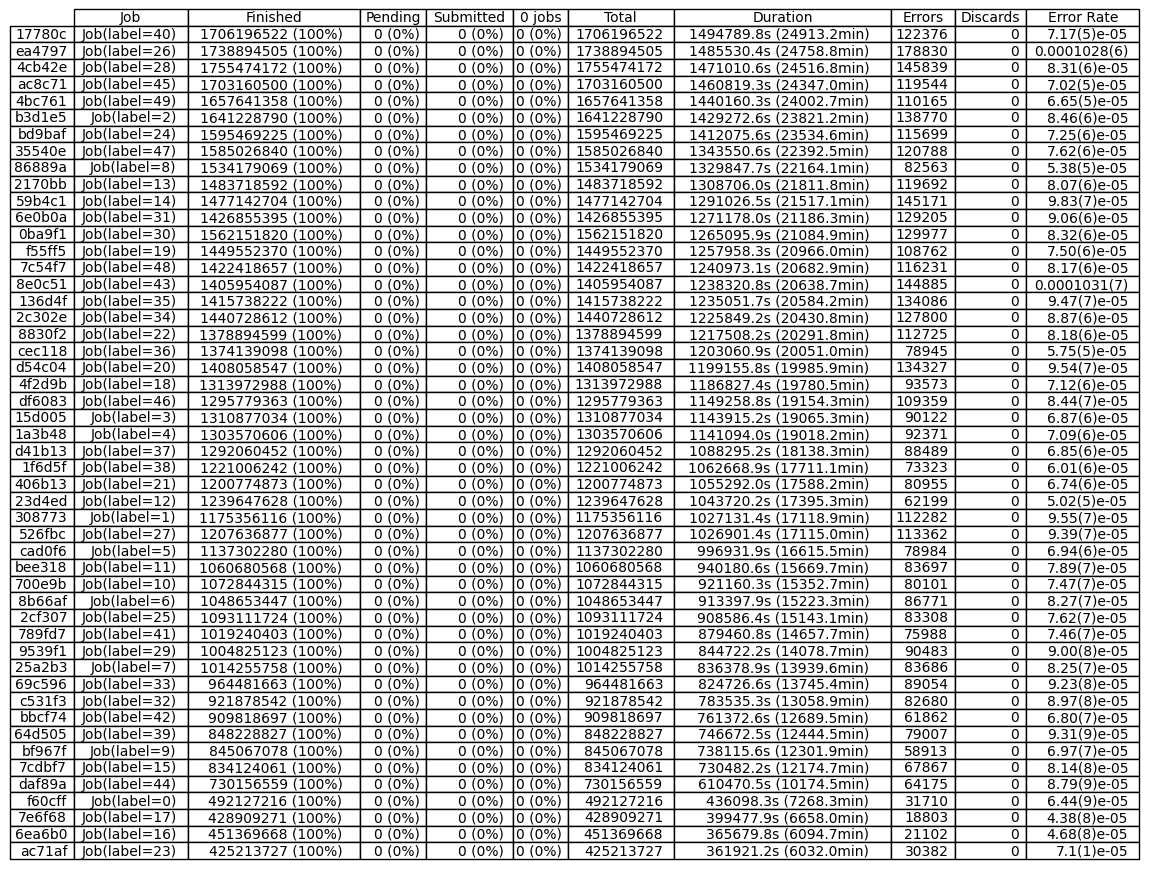

In [7]:
plotter = ConsistencyPlotter(label_vec)
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

## The rest of the notebook runs the evaluation

In [8]:
try:
    from dask_jobqueue import SLURMCluster
    from dask.distributed import Client
    n_workers = slurm_maximum_jobs // slurm_cores_per_node
    assert n_workers <= 200, "Yale HPC forbids submitting more than 200 jobs per hour"
    slurm_job_folder = os.path.join(os.path.abspath(os.getcwd()), "slurm_job")
    cluster = SLURMCluster(
        queue=slurm_partition,
        cores=slurm_cores_per_node,
        processes=slurm_cores_per_node,
        memory=f"{slurm_mem_per_job * slurm_cores_per_node} GB",
        walltime=slurm_walltime,
        job_extra_directives=[f'--out="{slurm_job_folder}/%j.out"', f'--error="{slurm_job_folder}/%j.err"'],
    )
    print(cluster.job_script())
    # cluster.scale(slurm_maximum_jobs)
    cluster.adapt(minimum=slurm_maximum_jobs, maximum=slurm_maximum_jobs)  # allow respawn
    shudown_cluster = True
except Exception as e:
    print(e)
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(n_workers=local_maximum_jobs)
    shudown_cluster = False

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenge
#SBATCH -n 1
#SBATCH --cpus-per-task=10
#SBATCH --mem=38G
#SBATCH -t 11:00:00
#SBATCH --out="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/different-cluster-node-limit-/slurm_job/%j.out"
#SBATCH --error="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/different-cluster-node-limit-/slurm_job/%j.err"

/home/yw729/.conda/envs/qec/bin/python -m distributed.cli.dask_worker tcp://10.181.184.83:41757 --name dummy-name --nthreads 1 --memory-limit 3.73GiB --nworkers 10 --nanny --death-timeout 60



/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38183 instead
  warnings.warn(


In [9]:
print(cluster.dashboard_link)
cluster

http://10.181.184.83:38183/status


Dashboard: http://10.181.184.83:38183/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.181.184.83:41757,Workers: 0
Dashboard: http://10.181.184.83:38183/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
if shudown_cluster:
    print("will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False")
with Client(cluster) as client:
    try:
        executor = MonteCarloJobExecutor(
            client,
            monte_carlo_function,
            jobs,
            filename=json_filename,
        )
        executor.execute(submitter, loop_callback=callback)
    finally:
        if shudown_cluster:
            print("shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False")
            client.shutdown()

will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False


shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False


2025-01-31 17:41:13,002 - distributed.scheduler - ERROR - Task monitored_job-67cef259aedba9be6cacc511e74cf70c marked as failed because 4 workers died while trying to run it


2025-01-31 17:41:13,003 - distributed.scheduler - ERROR - Task monitored_job-f1baa6497a8c59afb90d7d0893ad7efc marked as failed because 4 workers died while trying to run it


2025-01-31 17:41:13,004 - distributed.scheduler - ERROR - Task monitored_job-df4255711a6d01581c89fb4903df8db2 marked as failed because 4 workers died while trying to run it


2025-01-31 17:41:13,005 - distributed.scheduler - ERROR - Task monitored_job-b3dbd90dbff28b7a34a2a4ead97b8e8a marked as failed because 4 workers died while trying to run it
